## Create timeseries of CMIP6 chlorophyll and surface temperature for NOAA LME´s

This tutorial shows how you can use the newly released CMIP6 climate projections and hindcasts to visualize future trends within Large Marine Ecosystems (LMEs). Specifically, we will be looking at how chlorophyll and sea surface temperature are expected to change. For this exercise we need to read the polygons defining the boundaries of the LMEs, extract the CMIP6 data within the polygon, create a spatial average of the anomalies, and plot the result. We will calculate the anomalies using the climatology from the historical projections for the period 1961-1990. 

### Import, prepare, and setup
This tutorial requires a few Python modules you may ahve to install such as `xarray`, `gcsfs` (Google Cloud storage file system), `salem`, `geopandas` amongst others. In addition, the tutorial will be using some helper functions found in the `pices.py` file as well as Shapefile for the LME polygons found in the `data` folder.

In [3]:
import matplotlib
matplotlib.use('WebAgg')

# Date and time
from dateutil.relativedelta import relativedelta
import datetime

# Computational modules
import zarr
import dask.delayed as delayed
from dask import compute
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm
np.seterr(divide='ignore', invalid='ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(divide='ignore', invalid='ignore')
get_ipython().run_line_magic("matplotlib", "inline")
plt.rcParams["figure.figsize"] = 12, 6
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")


# Maps   
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray
import geopandas as gpd
from shapely.geometry import box, mapping

# Additional modules required
import sys
!{sys.executable} -m pip install --user cmip6_preprocessing
!{sys.executable} -m pip install --user rioxarray
!{sys.executable} -m pip install --user salem
!{sys.executable} -m pip install --user nc-time-axis

# Local files and utility functions
sys.path.append("./subroutines/")
import pices
import salem

#### Create a dask cluster
In Jupyterhub manually start a dask cluster and edit the Client tcp address below  

In [1]:
from dask.distributed import Client, progress
client = Client() 
client

/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43369 Dashboard: /user/trondkr/proxy/40297/status,Cluster Workers: 4 Cores: 16 Memory: 63.33 GB


#### Setup CMIP6 requirements
This is where you specify what variables and models you want to extract from Google Cloud CMIP6 archive. You can specify 
a number of settings such as experiment_ids, member_ids, and source_ids, however keep in mind that not all models may have available the selected variable as output, which would end in an error. The configuration is created as a class which is used for our convenience containing local definitions of variables. You can use the script `PivotTables` to check which models and variable combinations that are avaiilable on Google servers. If there are models or variables you would like to use that are missing you can submit an online request [here](https://docs.google.com/forms/d/e/1FAIpQLScFjA5IddqBs2Rc0xGbzn32NPq12TKr-b-8KGtXWyNDK5sJCg/viewform).

Perhaps most important to edit is the `start_date` and `end_date` for what time period you would like the final plots to show.

The Config_pices class is used to create an object containing all of the user settings and can be passed off to functions used later. 

In [2]:
class Config_pices():
    df = pd.read_csv(
    "https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv"
)
    fs = gcsfs.GCSFileSystem(token="anon", access="read_only")
   
    grid_labels = ["gr"]  # Can be gr=grid rotated, or gn=grid native
    member_ids = ["r1i1p1f1"]  #
    experiment_ids = ["ssp585"]  #'abrupt-4xCO2',
    source_ids = ["GFDL-CM4","CESM2-WACCM","CESM2"]
    variable_ids = ["chl","tos"]
    table_ids = ["Omon","Omon"]  # Amon=atmospheric variables, Omon=Ocean variables, SImon=sea-ice variables
    dset_dict = {}
    start_date="1950-01-01"
    end_date="2100-08-01"
    clim_start="1961-01-01"
    clim_end="1990-01-01"
    
    selected_depth=0
    LMES=['California Current','East Bering Sea','Gulf of Alaska',
          'Northern Bering - Chukchi Seas','West Bering Sea','Sea of Japan',
          'Oyashio Current','Kuroshio Current','East China Sea',
          'South China Sea','Sea of Okhotsk','Yellow Sea',
          'Aleutian Islands']

# Create the object
config_pices_obj = Config_pices()

NameError: name 'pd' is not defined

## Create a map of the selected LMEs
We start off by creating a map showing all of the LMEs for the PICES region. The ones we selected for deeper analysis
are highlighted with colors and LME number label, while the non-selected are shown as grey. This function is also used later to create a single map showing the LME where we also show trends and anomalies, which is why we send it information about the projection and axes.

In [4]:
def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]

In [5]:
def create_LME_figure(config_pices_obj, ax, LMES, projection, show):
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    extent = [-252, -100, 10, 65]
    ax.set_extent(extent)
    
    # Get the -180-180 projected shapefile containing LMEs to make it 
    # easy to plot across the Pacific Ocean
    shdf = pices.get_LME_records_plot()
    colors_rgb=create_colors(len(config_pices_obj.LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):
        
        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]
     
        if (LME_NAME in LMES):
            print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1: 
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'], 
                              projection,
                              facecolor=color, 
                              edgecolor='k')
            
            # Add the label LME_NUMBER of the selected LME at the center of the LME
            ax.annotate(s=LME_NUMBER, 
                        xy=(shdf_sel.centroid.x,shdf_sel.centroid.y), 
                        color="white",
                        fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'], 
                              projection,
                              facecolor='LightGray', 
                              edgecolor='k')  

    if show:
        plt.show()


Adding geometry for LME Sea of Okhotsk
Adding geometry for LME Gulf of Alaska
Adding geometry for LME Sea of Japan
Adding geometry for LME Oyashio Current
Adding geometry for LME California Current
Adding geometry for LME Kuroshio Current
Adding geometry for LME Yellow Sea
Adding geometry for LME East China Sea
Adding geometry for LME South China Sea
Adding geometry for LME West Bering Sea
Adding geometry for LME Aleutian Islands
Adding geometry for LME East Bering Sea
Adding geometry for LME Northern Bering - Chukchi Seas


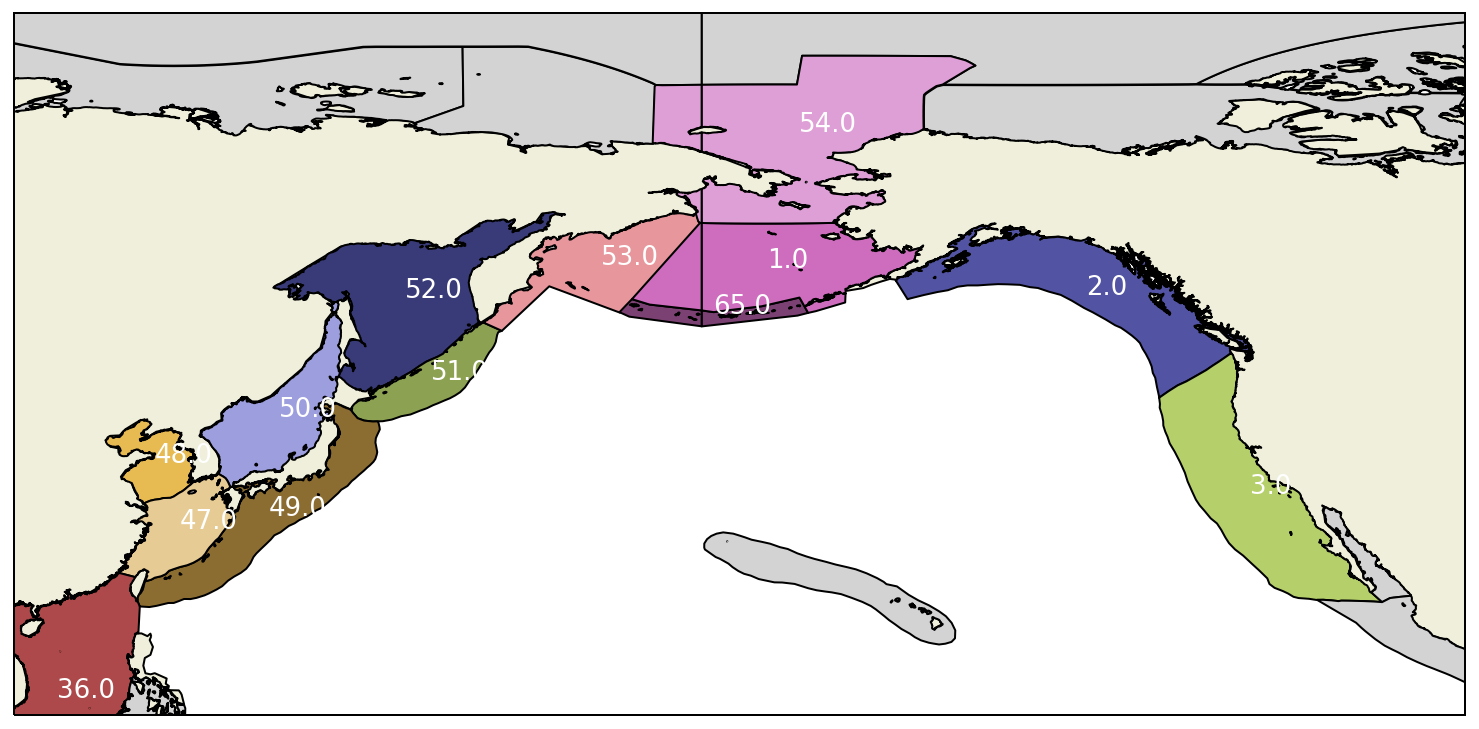

In [6]:
fig = plt.figure(figsize=(13, 8))
projection = ccrs.PlateCarree(central_longitude=-180)
ax = fig.add_subplot(111, projection=projection)
create_LME_figure(config_pices_obj,ax,config_pices_obj.LMES, projection,True)

## Extracting CMIP6 data 
Now that we know what areas we need to extract data for we need to query the Google Cloud data storage for what models and variables that are available for the various projections and simulations.

#### Narratives of the CMIP6 Shared Socio-economic Pathways
**See this excellent in-depth explainer of the SSP's by Carbonbrief for more info.**

**SSP1**: Sustainability – Taking the Green Road (Low challenges to mitigation and adaptation)
The world shifts gradually, but pervasively, toward a more sustainable path, emphasizing more inclusive development that respects perceived environmental boundaries. Management of the global commons slowly improves, educational and health investments accelerate the demographic transition, and the emphasis on economic growth shifts toward a broader emphasis on human well-being. Driven by an increasing commitment to achieving development goals, inequality is reduced both across and within countries. Consumption is oriented toward low material growth and lower resource and energy intensity.

**SSP2**: Middle of the Road (Medium challenges to mitigation and adaptation)
The world follows a path in which social, economic, and technological trends do not shift markedly from historical patterns. Development and income growth proceeds unevenly, with some countries making relatively good progress while others fall short of expectations. Global and national institutions work toward but make slow progress in achieving sustainable development goals. Environmental systems experience degradation, although there are some improvements and overall the intensity of resource and energy use declines. Global population growth is moderate and levels off in the second half of the century. Income inequality persists or improves only slowly and challenges to reducing vulnerability to societal and environmental changes remain.

**SSP3**: Regional Rivalry – A Rocky Road (High challenges to mitigation and adaptation)
A resurgent nationalism, concerns about competitiveness and security, and regional conflicts push countries to increasingly focus on domestic or, at most, regional issues. Policies shift over time to become increasingly oriented toward national and regional security issues. Countries focus on achieving energy and food security goals within their own regions at the expense of broader-based development. Investments in education and technological development decline. Economic development is slow, consumption is material-intensive, and inequalities persist or worsen over time. Population growth is low in industrialized and high in developing countries. A low international priority for addressing environmental concerns leads to strong environmental degradation in some regions.

**SSP4**: Inequality – A Road Divided (Low challenges to mitigation, high challenges to adaptation)
Highly unequal investments in human capital, combined with increasing disparities in economic opportunity and political power, lead to increasing inequalities and stratification both across and within countries. Over time, a gap widens between an internationally-connected society that contributes to knowledge- and capital-intensive sectors of the global economy, and a fragmented collection of lower-income, poorly educated societies that work in a labor intensive, low-tech economy. Social cohesion degrades and conflict and unrest become increasingly common. Technology development is high in the high-tech economy and sectors. The globally connected energy sector diversifies, with investments in both carbon-intensive fuels like coal and unconventional oil, but also low-carbon energy sources. Environmental policies focus on local issues around middle and high income areas.

**SSP5**: Fossil-fueled Development – Taking the Highway (High challenges to mitigation, low challenges to adaptation)
This world places increasing faith in competitive markets, innovation and participatory societies to produce rapid technological progress and development of human capital as the path to sustainable development. Global markets are increasingly integrated. There are also strong investments in health, education, and institutions to enhance human and social capital. At the same time, the push for economic and social development is coupled with the exploitation of abundant fossil fuel resources and the adoption of resource and energy intensive lifestyles around the world. All these factors lead to rapid growth of the global economy, while global population peaks and declines in the 21st century. Local environmental problems like air pollution are successfully managed. There is faith in the ability to effectively manage social and ecological systems, including by geo-engineering if necessary.

### Query the data
The dataset returned from the query based on the previous setup, needs to be checked for time dimension as various CMIP6 models handle that differently. If the time array 
uses a relative date (e.g. 0001 instead of 2001) then we add 2000 prior to converting to 
datetime64 format.

This query also preprocesses the data so that various models are using the same naming, coordinates etc. according to https://github.com/jbusecke/cmip6_preprocessing

In [7]:
config_pices_obj = pices.get_and_organize_cmip6_data(config_pices_obj)

Running historical query on data: 
 ==> source_id=='GFDL-CM4'and table_id=='Omon' and grid_label=='gr' and experiment_id=='historical' and variable_id=='chl'

Running projections query on data: 
 ==> source_id=='GFDL-CM4'and table_id=='Omon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='ssp585' and variable_id=='chl'

GFDL-CM4 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='GFDL-CM4'and table_id=='Omon' and grid_label=='gr' and experiment_id=='historical' and variable_id=='tos'

Running projections query on data: 
 ==> source_id=='GFDL-CM4'and table_id=='Omon' and member_id=='r1i1p1f1' and grid_label=='gr' and experiment_id=='ssp585' and variable_id=='tos'

GFDL-CM4 => Dates extracted range from 1950-01-16 12:00:00 to 2100-07-16 12:00:00

Running historical query on data: 
 ==> source_id=='CESM2-WACCM'and table_id=='Omon' and grid_label=='gr' and experiment_id=='historical' and variable_i

#### Plot the results within LMEs´
For each LME we will continue to plot the values of chlorophyll and sea surface temperature. The CMIP6 data are in monthly time resolution which for a period of 150 years creates a lot of data points. To allow the plots to be more readable we resample the data by averaging over 60 months (this can be chanegd to your value of choice). For SST we plot the actual values for each model as well as the SST anomalies from the climatology (1961-1990). For chlorophyll we plot the anomalies only. In the background we add a transparent layer showing teh standard deviations within each model to show the variability over time. Since we have to convert the datetime64 objects to CFDatetime objects as the CMIP6 data uses non-standard calendar (no-leap) Python will issue some warnings which we turn off by issuing: `import warnings; warnings.simplefilter('ignore')`


For more info on more advanced description of plotting options and datetime references see
[ref 1](http://danielrothenberg.com/gcpy/tutorials/xarray_overview.html)
[ref 2](http://xarray.pydata.org/en/stable/examples/ROMS_ocean_model.html)
or for datetime issues [ref 3](http://xarray.pydata.org/en/stable/weather-climate.html)
       

Working on LME: California Current
Adding geometry for LME California Current
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2_r1i1p1f1 variable name: tos


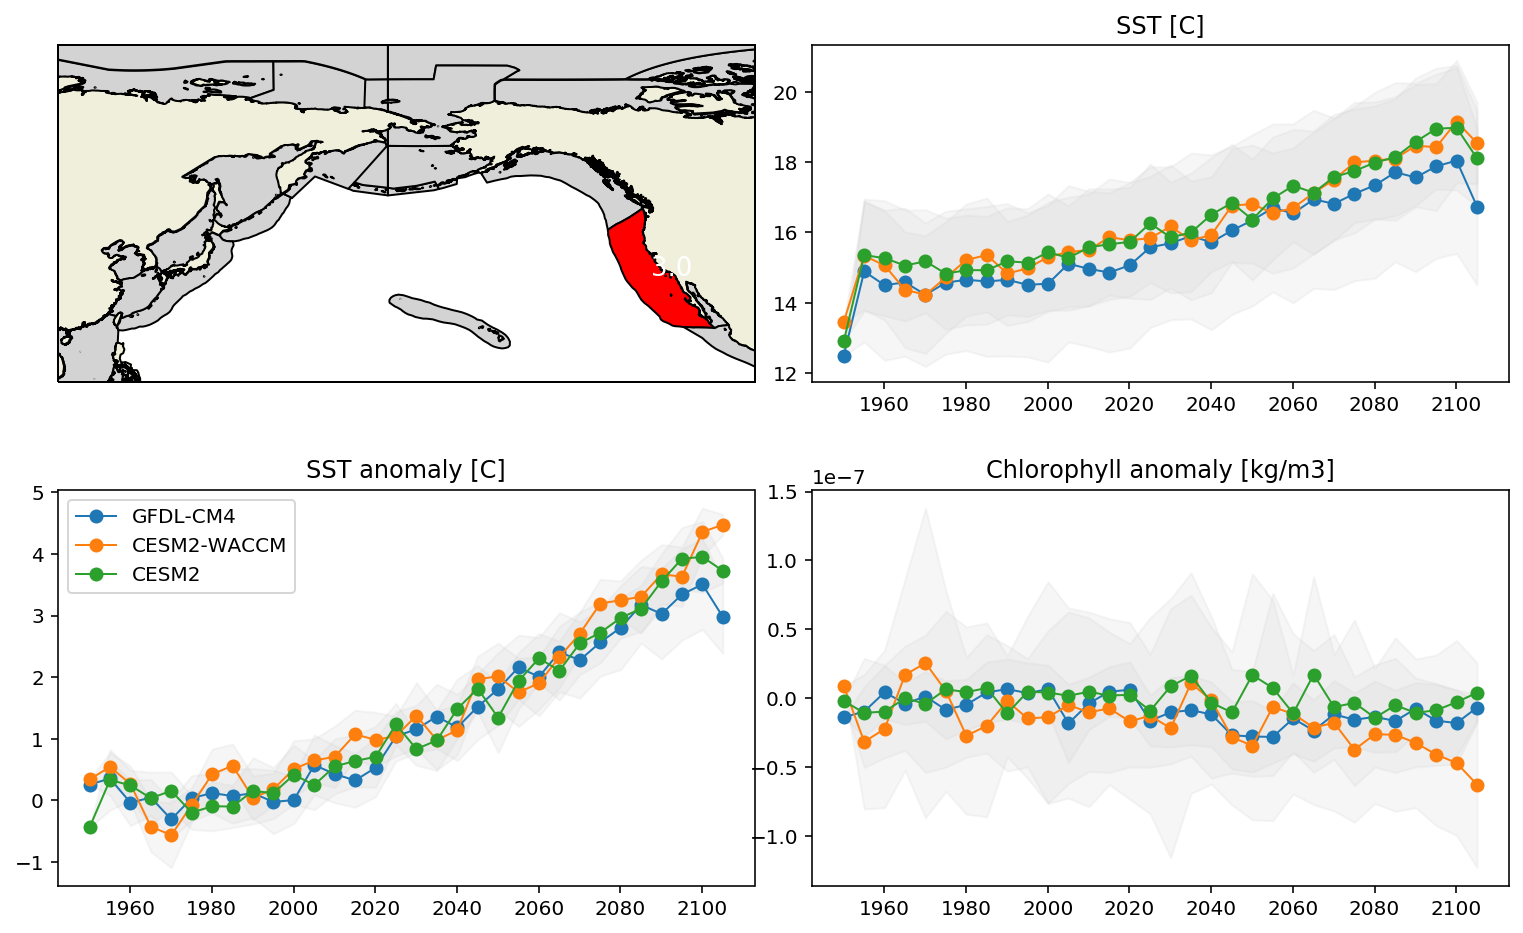

Working on LME: East Bering Sea
Adding geometry for LME East Bering Sea
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2_r1i1p1f1 variable name: tos


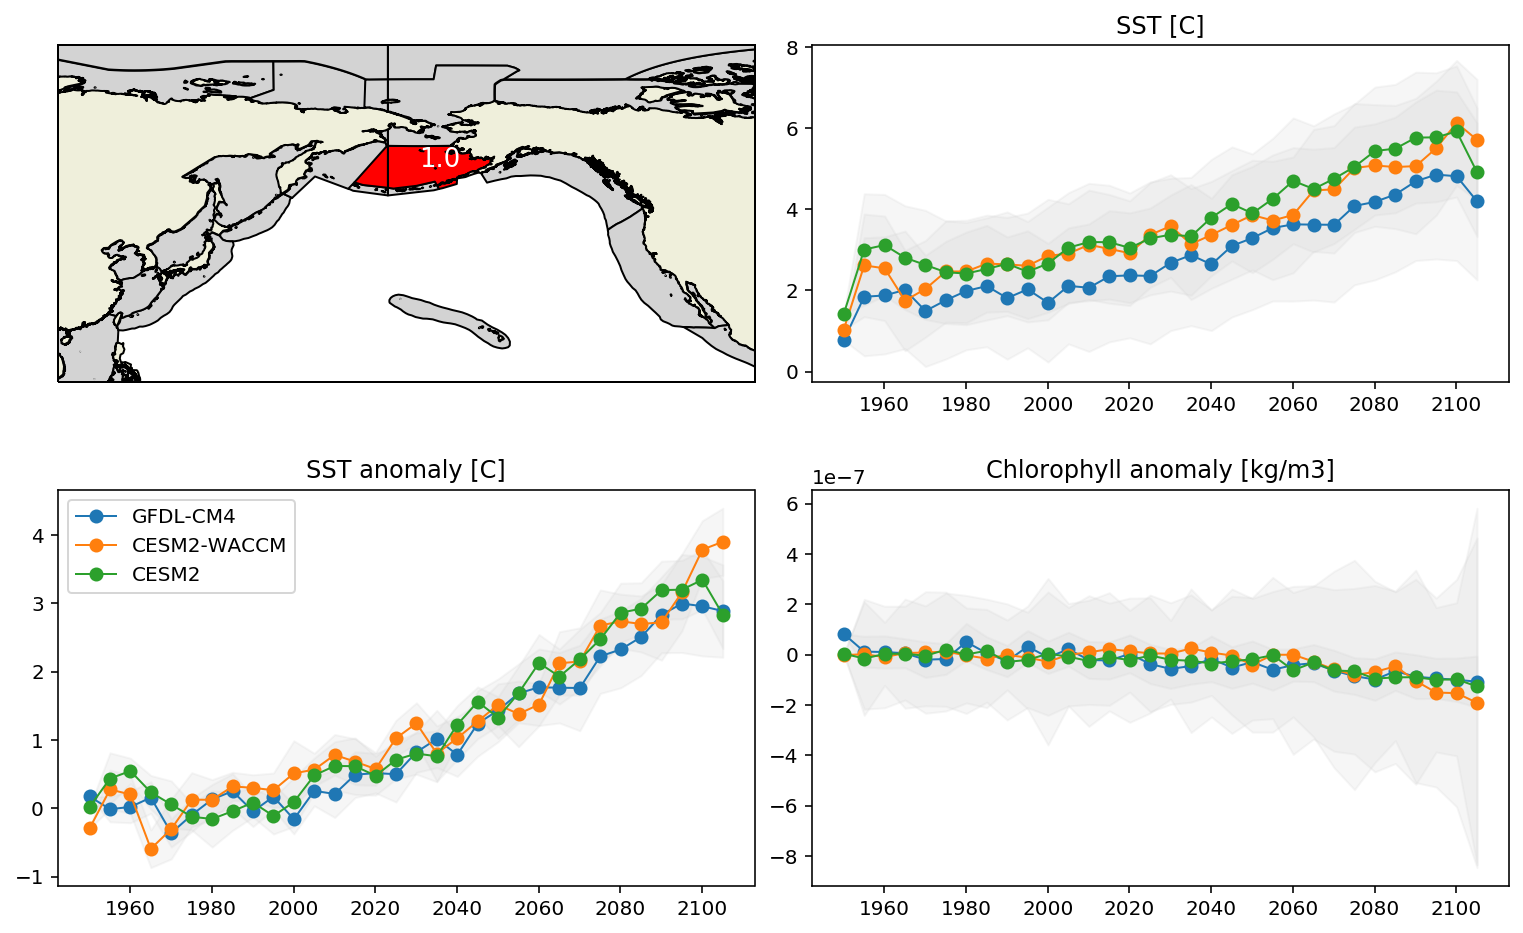

Working on LME: Gulf of Alaska
Adding geometry for LME Gulf of Alaska
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2_r1i1p1f1 variable name: tos


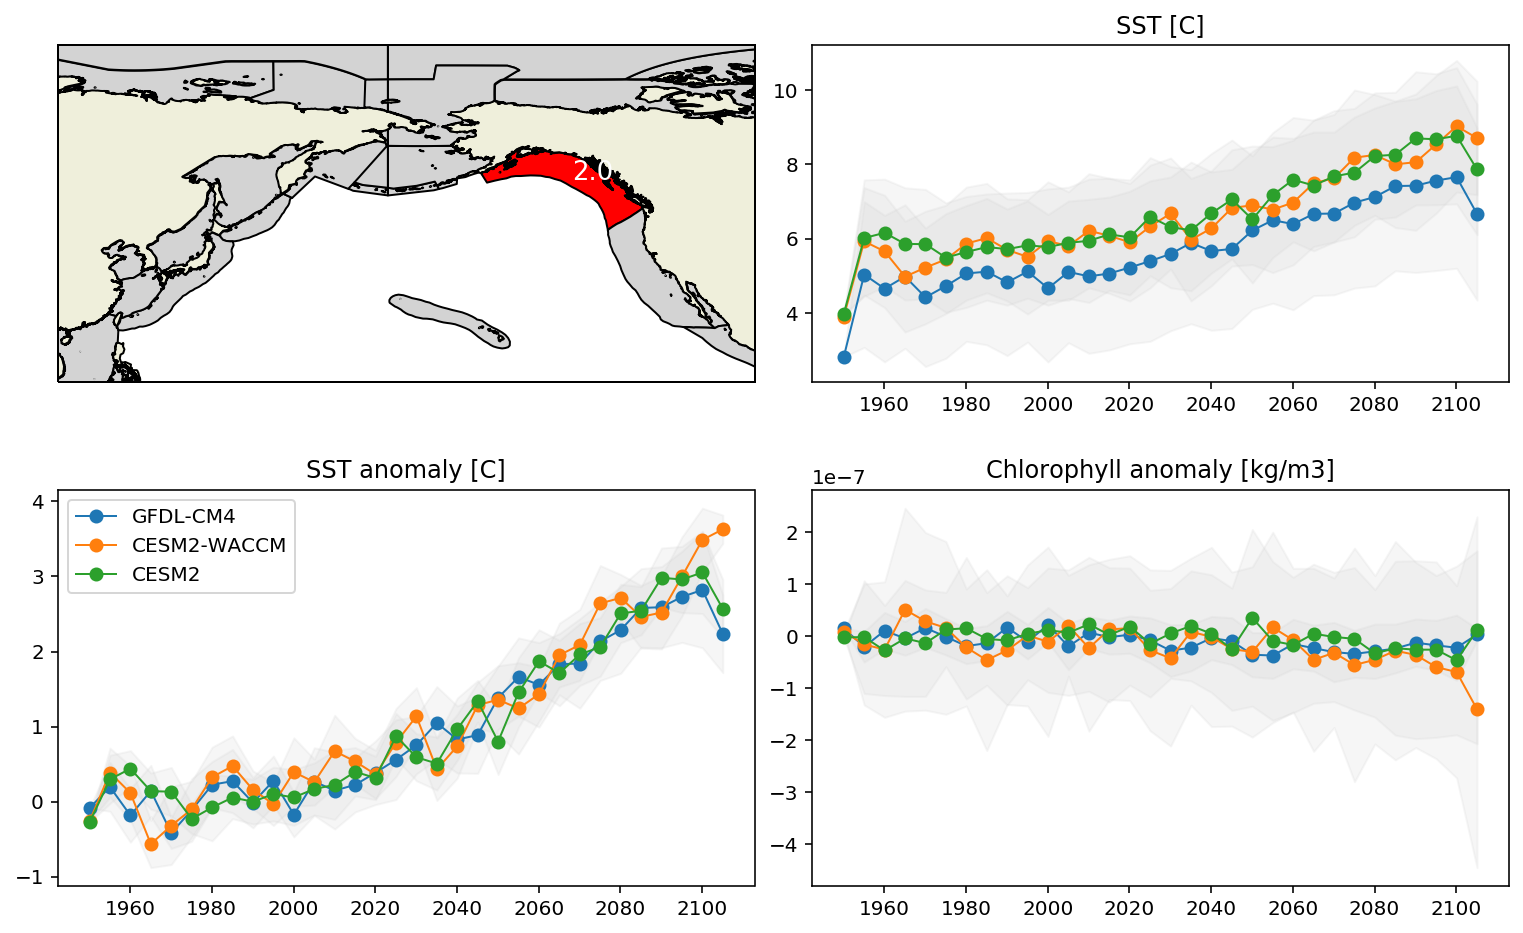

Working on LME: Northern Bering - Chukchi Seas
Adding geometry for LME Northern Bering - Chukchi Seas
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2_r1i1p1f1 variable name: tos


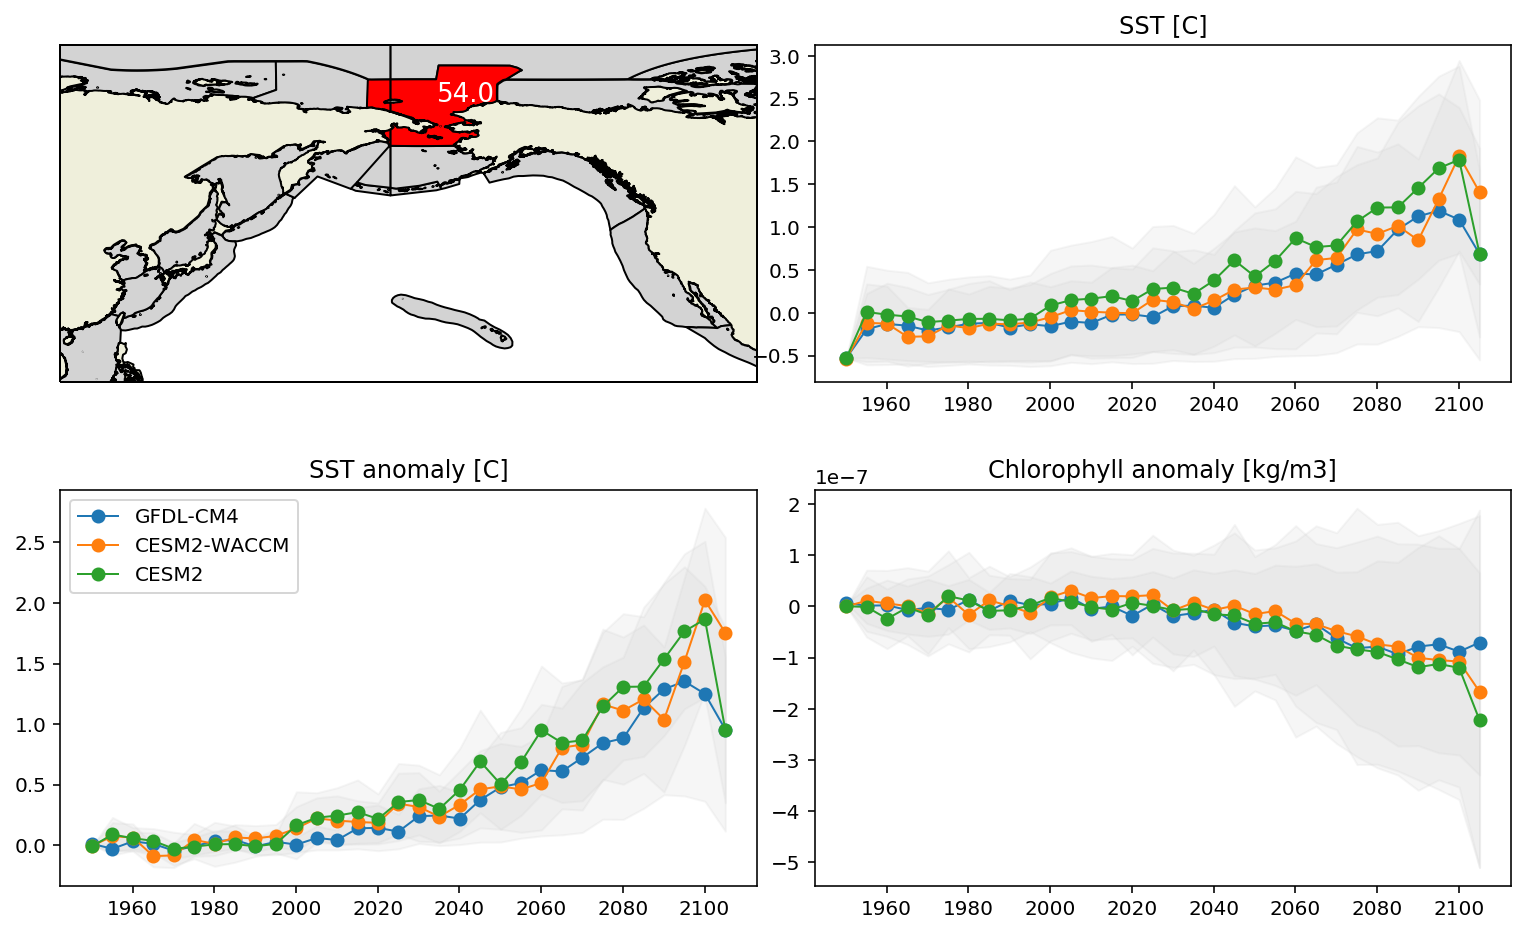

Working on LME: West Bering Sea
Adding geometry for LME West Bering Sea
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2-WACCM_r1i1p1f1 variable name: tos
=> model: chl_ssp585_gr_CESM2_r1i1p1f1 variable name: chl
=> model: tos_ssp585_gr_CESM2_r1i1p1f1 variable name: tos


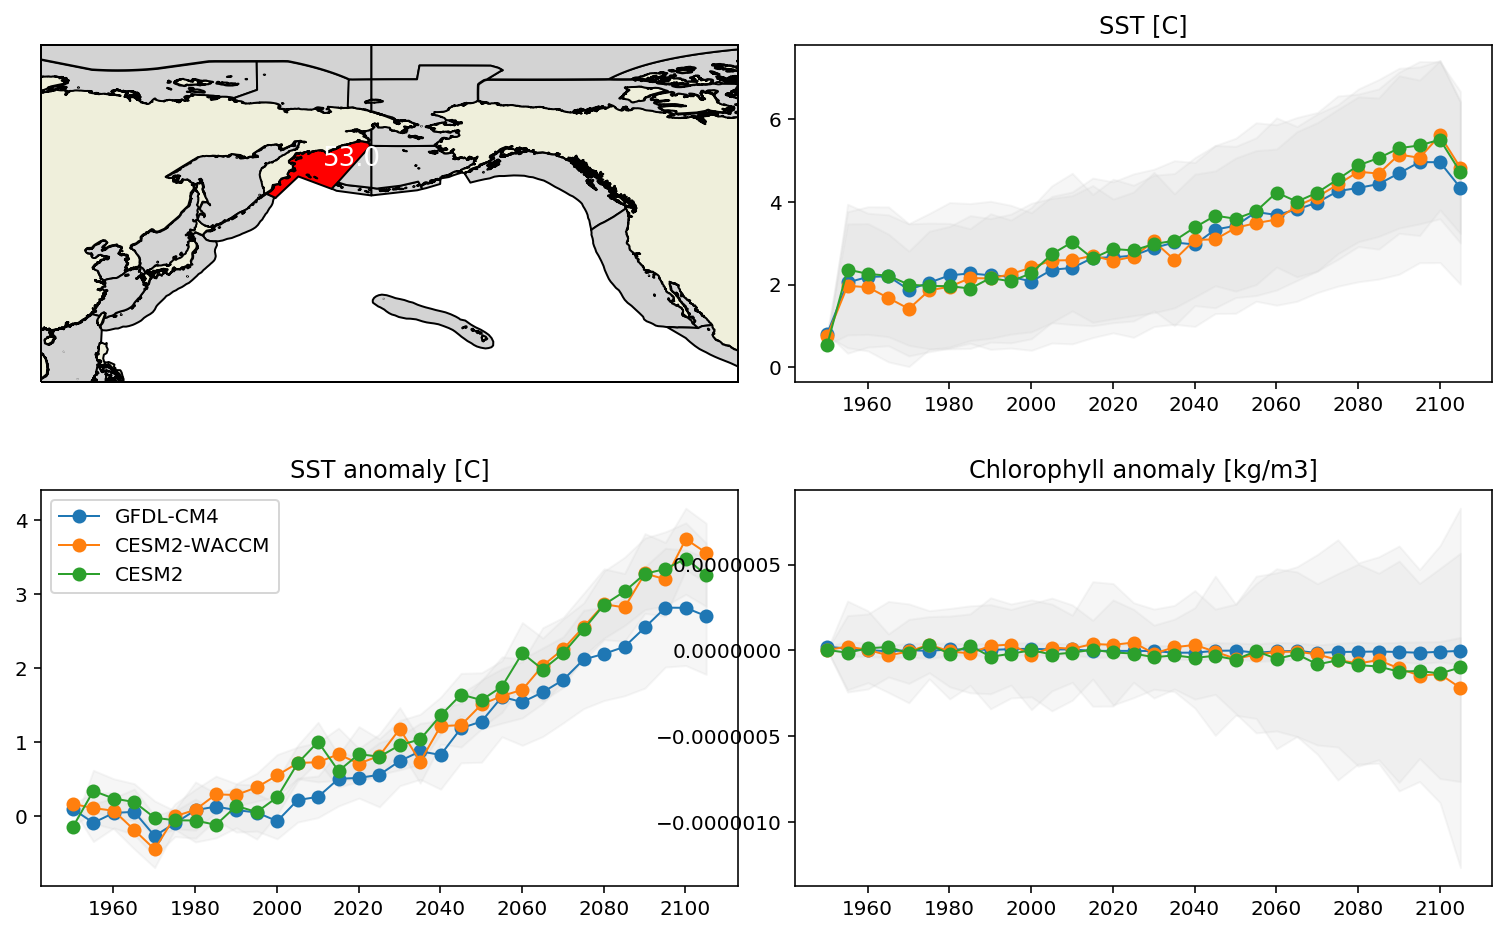

Working on LME: Sea of Japan
Adding geometry for LME Sea of Japan
=> model: chl_ssp585_gr_GFDL-CM4_r1i1p1f1 variable name: chl


In [ ]:
import warnings; warnings.simplefilter('ignore')

for LME_NAME in config_pices_obj.LMES:
    
    print("Working on LME: {}".format(LME_NAME))
    
    # Extract the polygon defining the boundaries of the LME
    shdf = pices.get_LME_records()
    shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]
       
    # Setup the figure panels
    fig = plt.figure(figsize=(13, 8))
    projection=ccrs.PlateCarree(central_longitude=-180)
    
    ax1 = fig.add_subplot(211, projection=projection)
    divider = make_axes_locatable(ax1)
    ax2 = divider.new_horizontal(size="100%", pad=0.4, axes_class=plt.Axes)
    fig.add_axes(ax2)
    ax3 = fig.add_subplot(212)
    divider = make_axes_locatable(ax3)
    ax4 = divider.new_horizontal(size="100%", pad=0.4, axes_class=plt.Axes)
    fig.add_axes(ax4)
    
    # Create the map of the LME bopundaries and color it. 
    # The active LME has color while the others are grey.    
    create_LME_figure(config_pices_obj,ax1,[LME_NAME],projection,False)
        
    # http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html
    # http://xarray.pydata.org/en/stable/examples/monthly-means.html
    
    # Loop overall datasets, extract data within region and plot
    for key in config_pices_obj.dset_dict:
        ds=config_pices_obj.dset_dict[key]
        var_name = key.split("_")[0]
        model_name = key.split("_")[3]
        print("=> model: {} variable name: {}".format(key, var_name))
          
        # Convert coordinates to  -180 to 180 (required by rioxarray clip function)
        ds = ds.assign_coords(x=(((ds.x + 180) % 360) - 180)).sortby('x')
       
        # For a for a rectangular grid the cosine of the latitude is proportional to the grid cell area.
        area_ds = ds*np.cos(np.deg2rad(ds[var_name].y))
           
        tos_proj = area_ds[var_name].salem.transform(area_ds[var_name])

        # We need to add the projection to the dataset. Lon and lat projections are WGS84 (epsg:4326)
        tos_proj.rio.set_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
        
        
        # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
        # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function
        clipped = tos_proj.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos_proj.rio.crs)
      #  print("LME region: lon ({},{}) lat ({},{})".format(np.min(clipped.x.values), np.max(clipped.x.values),np.min(clipped.y.values), np.max(clipped.y.values)))
        
        lme_var = clipped.mean(dim=["x","y"])
        lme_climatology = lme_var.sel(time=slice(config_pices_obj.clim_start, config_pices_obj.clim_end)).groupby('time.month').mean('time',keep_attrs=True)
        lme_anomaly = (lme_var.groupby('time.month') - lme_climatology)
          
        average_period="60M"
        if var_name in ["tos"]:
            tos_timeseries = lme_var.resample(time=average_period)
            tos = tos_timeseries.mean()
            tos_std = tos_timeseries.std()
            
            time = tos.indexes['time'].to_datetimeindex()
            ax2.fill_between(time, tos-tos_std, tos+tos_std, color='lightgrey', alpha=0.2)
            ax2.plot(time,tos,marker='o',linewidth=1.0)
            ax2.title.set_text("SST [C]")
            
            tos_anomaly_timeseries = lme_anomaly.resample(time=average_period)
            tos_anomaly = tos_anomaly_timeseries.mean()
            tos_anomaly_std = tos_anomaly_timeseries.std()
            
            ax3.fill_between(time, tos_anomaly-tos_anomaly_std, tos_anomaly+tos_anomaly_std, color='lightgrey', alpha=0.2,label=None)
            ax3.plot(time,tos_anomaly,marker='o',linewidth=1.0, label=model_name)
            ax3.title.set_text("SST anomaly [C]")
        else:
            chl_timeseries = lme_anomaly.resample(time=average_period)     
            chl = chl_timeseries.mean()
            chl_std = chl_timeseries.std()
             
            time = chl.indexes['time'].to_datetimeindex()
            ax4.fill_between(time, chl-chl_std, chl+chl_std, color='lightgrey', alpha=0.2)
            ax4.plot(time,chl,marker='o',linewidth=1.0)
            ax4.title.set_text("Chlorophyll anomaly [kg/m3]")
    ax3.legend(loc="upper left")
    plt.show()


In [ ]:
client.close()